# Descriptor selection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from lazypredict.Supervised import LazyRegressor

/hits/fast/mbm/treydewk/.venv/venv_up/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
data = pd.read_pickle('data_complete_w_descriptors')

In [3]:
Y = data['Ea']
X = data.drop(
    columns = [
        'hash_u1', 'rad_name', 'nms', 'hash_u2', 'e_max_key',
        'e_max', 'e_00', 'e_03', 'e_04', 'e_05', 'e_06', 'e_07', 'e_10',
        'h_name', 'meta_path', 'intramol',
        'central_atom_idx_1', 'central_atom_idx_2',
        'central_atom_idx', 'e_01', 'e_02', 'e_08', 'e_09', 'e_s_opt',
        'e_ts_opt', 'e_e_opt', 'trajectory', 'frame', 'indices', 'charge',
        'traj_H', 'Ea_opt', 'dG_ts_2_opt', 'Ea', 'dG_ts_2', 'dG', 'dG_opt',
        'rad_name_s', 'h_name_s', 'reaction', 'Err', 'dG_ts_1_opt', 'dG_ts_1',
        'Err_s', 'Err_ts', 'Err_e', 'trans_mean', 'Ea_trans_mean', 'rad_ref',
        'rad_ref_idx', 'h_ref', 'h_ref_idx', 'rad_chem_name', 'H_chem_name',
        'rad_ref_comp', 'H_ref_comp', 'Ea', 'SMILES_rad', 'pdb_rad'
    ], axis=1
)

In [4]:
# Mordred errors
to_drop = []
for column in X.columns:
    if isinstance(X[column].to_list()[1], str):
        to_drop.append(column)

In [5]:
X.drop(to_drop, axis=1, inplace=True)

In [6]:
X.shape

(6150, 2794)

In [7]:
X.dropna(axis=1, inplace=True) #needs to be performed for normalization, PCA and LazyRegressor (doesn't work with NaN's)
### Normalize data to zero mean and unit variance
params = list(X.columns)
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns = params)

In [8]:
X_scaled.shape

(6150, 2791)

In [9]:
### Drop highly correlated descriptors
cov_df = X_scaled.corr().abs() # compute pairwise correlation of columns
mask = np.tril(np.ones_like(cov_df, dtype=bool)) # lower triangle of Boolean array
cov_masked = cov_df.mask(mask) # replace values where the condition is true with NaNs
to_drop = [c for c in cov_masked.columns if any(cov_masked[c] > 0.70)]
#print('Dropping these correlated features:\n', to_drop)
X_clean = X_scaled.drop(to_drop, axis = 1)

In [10]:
X_clean.shape

(6150, 653)

In [11]:
### PCA
pca = PCA(n_components=20)
projected = pca.fit_transform(X_clean)
PC1, PC2, PC3 = projected[:,0], projected[:,1], projected[:,2]
# variance
PC1_var = round(pca.explained_variance_ratio_[0]*100)
PC2_var = round(pca.explained_variance_ratio_[1]*100)
PC3_var = round(pca.explained_variance_ratio_[2]*100)
cumulative = round(np.array([pca.explained_variance_ratio_[i]*100 for i in range(20)]).sum())
print(f'Explained variation of first three principal components:\nPC1: {PC1_var}%, PC2:{PC2_var}% and {PC3_var}%')
print(f'Cumulative variance of first twenty components: {cumulative}%')

Explained variation of first three principal components:
PC1: 8%, PC2:7% and 6%
Cumulative variance of first twenty components: 76%


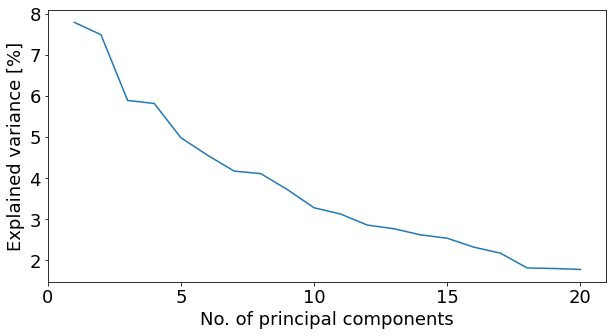

In [12]:
fs = 18
fig, ax = plt.subplots(figsize = (10,5))
PC_var = [pca.explained_variance_ratio_[i]*100 for i in range(20)]
ax.plot(range(1,21), PC_var)

ax.set_xlabel('No. of principal components', fontsize = fs)
ax.set_xticks([0,5,10,15,20])
ax.set_ylabel('Explained variance [%]', fontsize = fs)
ax.tick_params(labelsize = fs)
plt.show()

In [33]:
### Univariate feature selection
selector = SelectKBest(f_regression, k = 20)
selector.fit(X_clean, Y)
cols = selector.get_support(indices=True)
X_best = X_clean.iloc[:,cols]

In [34]:
print('20 best descriptors:', list(X_best.columns))

20 best descriptors: ['translation', 'H_BDE', 'bur_vol_iso_rad', 'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad', 'NdNH_rad', 'SMR_VSA4_rad', 'max_spin_H', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H', 'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H', 'VSA_EState7_H']


In [35]:
print([selector.pvalues_[col] for col in cols])

[0.0, 6.372814740546367e-07, 7.734513868234653e-08, 1.4376411308516652e-07, 4.5003725032824326e-08, 5.407876526882081e-14, 1.1664842267096518e-09, 5.484747379596141e-06, 5.201663586228088e-08, 1.2743680355692025e-07, 7.835771971409397e-07, 5.925747019348466e-08, 9.05709260791883e-07, 8.15004262656545e-10, 2.3153798720708543e-10, 2.3557750649299142e-08, 8.167065923908514e-07, 1.0248423664853672e-10, 2.5731072914142078e-08, 1.8946716196897947e-07]


In [38]:
print([selector.scores_[col] for col in cols])

[21267.791640391046, 24.84813839122122, 28.941691933070864, 27.736142157677303, 29.996264451051772, 56.841351739759915, 37.13933412267937, 20.69652492052225, 29.71412200043563, 27.97044838501894, 24.448275913379884, 29.46028734648845, 24.168157305775118, 37.842945726236074, 40.31545984698248, 31.258423853503775, 24.368181099890844, 41.919135960417904, 31.086253834684744, 27.19989466058472]


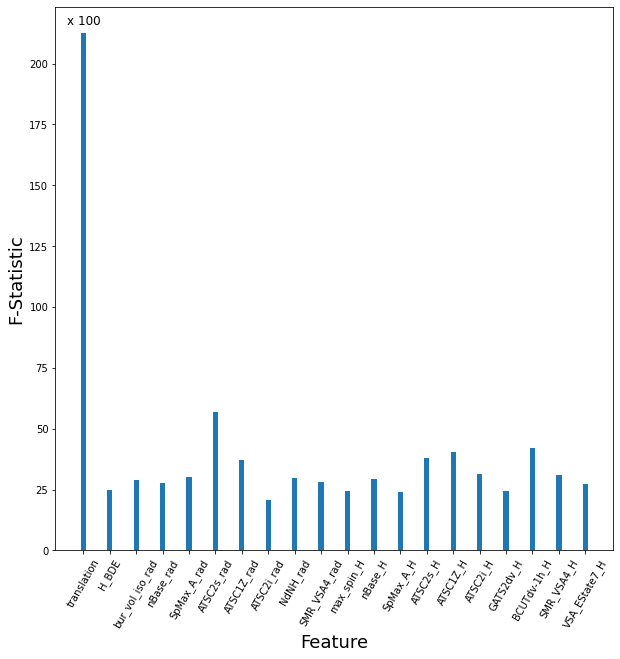

In [53]:
scores = [selector.scores_[col] for col in cols]
scores[0] /= 100

fig, ax = plt.subplots(figsize = (10,10))
ax.bar(
    X_best.columns, scores, width=0.2
)

rects = ax.patches
height = rects[0].get_height()
ax.text(
    rects[0].get_x() + rects[0].get_width() / 2, height + 2, 'x 100', ha="center", va="bottom", fontsize = 12
)

fs = 18
ax.set_xlabel('Feature', fontsize=fs)
ax.set_ylabel('F-Statistic', fontsize=fs)
# ax.tick_params(labelsize = fs)
ax.tick_params(axis = 'x', rotation = 60)
plt.show()

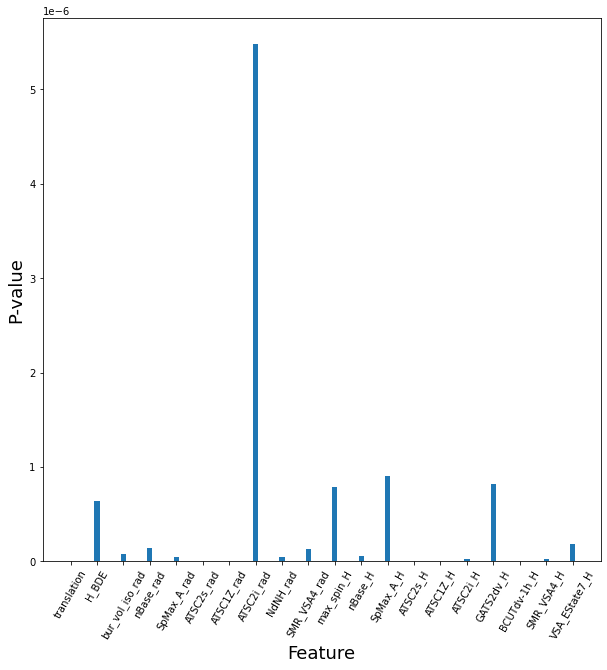

In [51]:
pvalues = [selector.pvalues_[col] for col in cols]
fig, ax = plt.subplots(figsize = (10,10))
ax.bar(
    X_best.columns, pvalues[:20], width=0.2
)

fs = 18
ax.set_xlabel('Feature', fontsize=fs)
ax.set_ylabel('P-value', fontsize=fs)
ax.tick_params(axis = 'x', rotation = 60)
plt.show()

# Lazy predict

In [18]:
### Data splitting
X_train, X_test, Y_train, Y_test = train_test_split(X_best, Y, test_size = 0.2, random_state = 1)

### Apply on various ML models using Lazy Predict
models, predictions = LazyRegressor(ignore_warnings=False).fit(X_train, X_test, Y_train, Y_test)

 19%|███████████████████████▌                                                                                                    | 8/42 [00:00<00:01, 17.30it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:14<00:00,  2.82it/s]


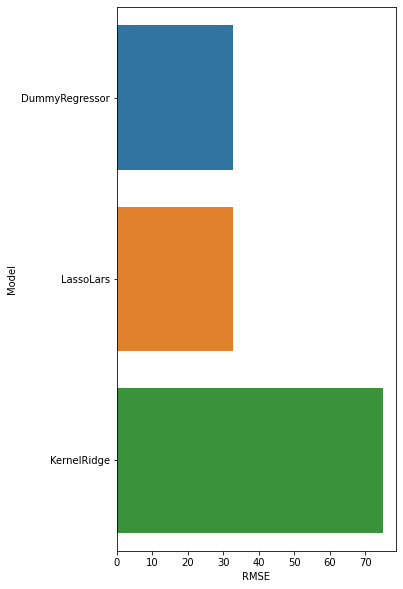

In [19]:
plt.figure(figsize=(5,10))
ax = sb.barplot(y=models.index[-4:-1], x = 'RMSE', data = models[-4:-1])

(0.0, 1.0)

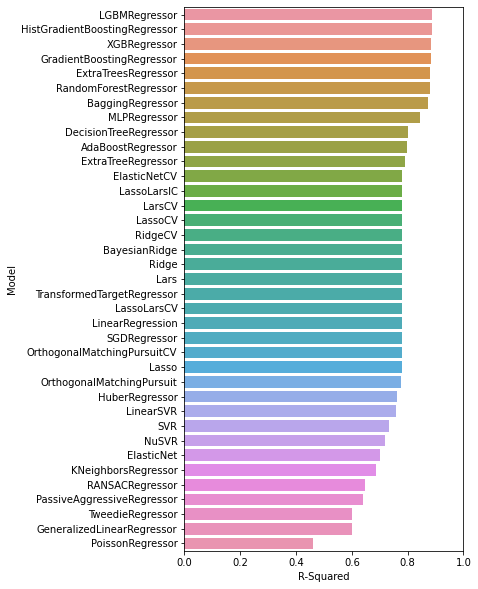

In [20]:
plt.figure(figsize=(5,10))
ax = sb.barplot(y=models.index[:-4], x = 'R-Squared', data = models[:-4])
ax.set_xlim(0,1)

In [21]:
from xgboost.sklearn import XGBRegressor

Training score:  0.9745012637731274
Test MAE: 7.15
Accuracy of Model with Cross Validation is: -7.206990287396373 (+/- 0.20)


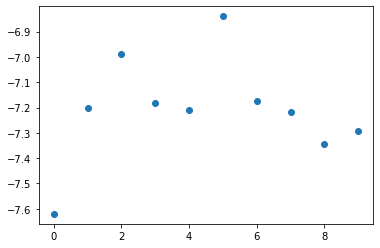

In [30]:
### Peform 10-fold cross-validation to estimate the accuracy of the model
model = XGBRegressor()
model.fit(X_train, Y_train)
score = model.score(X_train, Y_train)  
print("Training score: ", score)
ypred = model.predict(X_test)
diff = np.array(Y_test - ypred)
mae = np.abs(diff).mean()
print("Test MAE: %.2f" % mae)
#perform 10 fold crossvalidation to estimate accuracy of the model using the training data
mae = cross_val_score(model, X_train, Y_train, scoring='neg_mean_absolute_error', cv = KFold(n_splits=10))
plt.plot(mae, 'o')
#plt.ylim(0, 1.1)
plt.show 
print("Accuracy of Model with Cross Validation is:", mae.mean(), "(+/- %0.2f)" % mae.std())

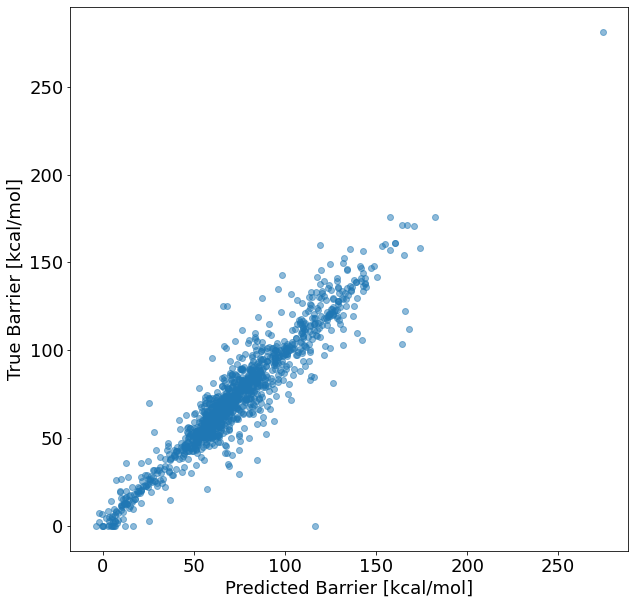

In [31]:
fs = 18
fig, ax = plt.subplots(figsize = (10,10))

ax.scatter(ypred, Y_test, marker = 'o', alpha = 0.5)
ax.set_ylabel('True Barrier [kcal/mol]', fontsize = fs)
ax.set_xlabel('Predicted Barrier [kcal/mol]', fontsize = fs)
ax.tick_params(labelsize = fs)
plt.show()

In [32]:
import lightgbm as ltb

Training score:  0.9319814164085448
Test MAE: 7.19
Accuracy of Model with Cross Validation is: -7.202073619703533 (+/- 0.28)


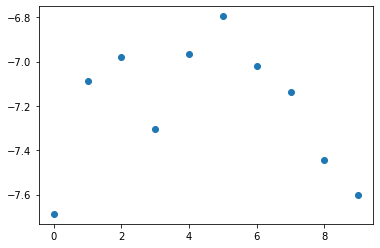

In [33]:
### Peform 10-fold cross-validation to estimate the accuracy of the model
model = ltb.LGBMRegressor()
model.fit(X_train, Y_train)
score = model.score(X_train, Y_train)  
print("Training score: ", score)
ypred = model.predict(X_test)
diff = np.array(Y_test - ypred)
mae = np.abs(diff).mean()
print("Test MAE: %.2f" % mae)
#perform 10 fold crossvalidation to estimate accuracy of the model using the training data
mae = cross_val_score(model, X_train, Y_train, scoring='neg_mean_absolute_error', cv = KFold(n_splits=10))
plt.plot(mae, 'o')
#plt.ylim(0, 1.1)
plt.show 
print("Accuracy of Model with Cross Validation is:", mae.mean(), "(+/- %0.2f)" % mae.std())

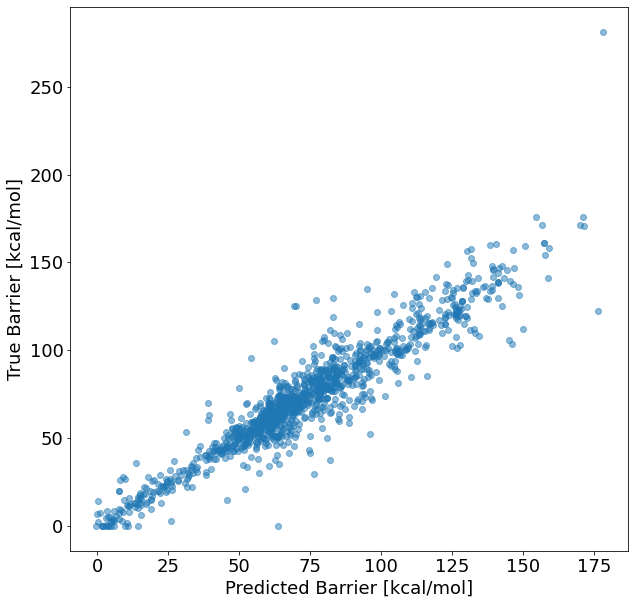

In [34]:
fs = 18
fig, ax = plt.subplots(figsize = (10,10))

ax.scatter(ypred, Y_test, marker = 'o', alpha = 0.5)
ax.set_ylabel('True Barrier [kcal/mol]', fontsize = fs)
ax.set_xlabel('Predicted Barrier [kcal/mol]', fontsize = fs)
ax.tick_params(labelsize = fs)
plt.show()

In [35]:
from sklearn.ensemble import HistGradientBoostingRegressor

Training score:  0.9305401604870897
Test MAE: 7.26
Accuracy of Model with Cross Validation is: -7.2268162296056975 (+/- 0.28)


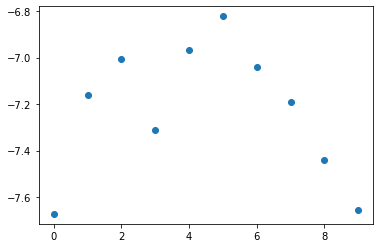

In [36]:
### Peform 10-fold cross-validation to estimate the accuracy of the model
model = HistGradientBoostingRegressor()
model.fit(X_train, Y_train)
score = model.score(X_train, Y_train)  
print("Training score: ", score)
ypred = model.predict(X_test)
diff = np.array(Y_test - ypred)
mae = np.abs(diff).mean()
print("Test MAE: %.2f" % mae)
#perform 10 fold crossvalidation to estimate accuracy of the model using the training data
mae = cross_val_score(model, X_train, Y_train, scoring='neg_mean_absolute_error', cv = KFold(n_splits=10))
plt.plot(mae, 'o')
#plt.ylim(0, 1.1)
plt.show 
print("Accuracy of Model with Cross Validation is:", mae.mean(), "(+/- %0.2f)" % mae.std())

# Evaluate the performance of the best performing regressors similar to the NNs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score

In [2]:
### Load input data ###
data = pd.read_pickle('data_complete_final')
data.dropna(axis = 1, inplace = True)
data = data.drop(columns = [
    'rad_name', 'h_name', 'hash_u1', 'hash_u2', 'e_max_key', 'e_max', 'e_00', 'e_03', 'e_04',
    'e_05', 'e_06', 'e_07', 'e_10', 'meta_path', 'dG', 'rad_name_s',
    'h_name_s', 'reaction', 'trans_mean', 'Ea_trans_mean', 'rad_ref',
    'rad_ref_idx', 'h_ref', 'h_ref_idx', 'bur_vol_default_rad', 'bur_vol_2A_rad',
    'bur_vol_default_H', 'bur_vol_2A_H'
], axis = 1)

In [3]:
# compute enthalpies of reaction to use as a direct input
BDE_rad = data['rad_BDE']
BDE_H = data['H_BDE']
Delta_H = BDE_H - BDE_rad
Delta_H_df = pd.DataFrame(Delta_H, columns=['Delta_H'])

In [5]:
def unpack_column(dataframe_in, column):
    dataframe = dataframe_in.reset_index(drop=True)

    if len(dataframe[column][0].shape) > 1:
        max_length = max([len(row[0]) for row in dataframe[column]])
    else:
        max_length = max([len(row) for row in dataframe[column]])

    unpacked = np.empty((len(dataframe[column]), max_length))

    for i, row in zip(range(len(dataframe[column])), dataframe[column]):
        if len(row.shape) > 1:
            row = row[0]

        length_diff = max_length-len(row)
        if length_diff > 0:
            diff = np.zeros(max_length-len(row))
            expanded = np.concatenate((row, diff), axis=1)
            unpacked[i] = expanded
        else:
            unpacked[i] = row

    return pd.DataFrame(unpacked)

def drop_zeros(dataframe):
    df = dataframe.loc[:, (dataframe != 0).any(axis = 0)]
    return df
    
def unpack_join(dataframe, columns):
    unpacked_dfs = []
    for column in columns:
        unpacked_dfs.append(unpack_column(dataframe, column))

    dataframe_compl = dataframe.reset_index(drop=True)
    dataframe_compl.drop(columns = columns, inplace=True)
    for i, df in zip(range(len(unpacked_dfs)), unpacked_dfs):
        dataframe_compl = dataframe_compl.join(df, lsuffix = '_{}'.format(i-1) , rsuffix = '_{}'.format(i))
    
    return dataframe_compl  

def plot_cross_val_scores(dataframe):
    sb.set_style('ticks')
    ax = sb.violinplot(x="Model", y="MAE [kcal/mol]", data=dataframe, inner=None, orient='v')
    ax = sb.swarmplot(x="Model", y="MAE [kcal/mol]", data=dataframe, color='black', edgecolor='black')

## SOAP input data

In [5]:
data_soap_se = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'soap_H_start', 'soap_H_end'
]]

data_soap = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'soap_H_start'
]]

data_soap_se_noBDEs = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'soap_H_start', 'soap_H_end'
]]

data_soap_noBDEs = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'soap_H_start'
]]

data_soap_DeltaH = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'soap_H_start', 'soap_H_end'
]]
data_soap_DeltaH = data_soap_DeltaH.join(Delta_H_df)

In [6]:
data_soap_se_unpacked = unpack_join(data_soap_se, ['soap_H_start', 'soap_H_end'])
data_soap_se_unpacked = drop_zeros(data_soap_se_unpacked)

data_soap_unpacked = unpack_join(data_soap, ['soap_H_start'])
data_soap_unpacked = drop_zeros(data_soap_unpacked)

data_soap_se_noBDEs_unpacked = unpack_join(data_soap_se_noBDEs, ['soap_H_start', 'soap_H_end'])
data_soap_se_noBDEs_unpacked = drop_zeros(data_soap_se_noBDEs_unpacked)

data_soap_noBDEs_unpacked = unpack_join(data_soap_noBDEs, ['soap_H_start'])
data_soap_noBDEs_unpacked = drop_zeros(data_soap_noBDEs_unpacked)

data_soap_DeltaH = unpack_join(data_soap_DeltaH, ['soap_H_start', 'soap_H_end'])
data_soap_DeltaH = drop_zeros(data_soap_DeltaH)

In [7]:
data_soap_se_target = data_soap_se_unpacked.pop('Ea')
data_soap_target = data_soap_unpacked.pop('Ea')
data_soap_se_noBDEs_target = data_soap_se_noBDEs_unpacked.pop('Ea')
data_soap_noBDEs_target = data_soap_noBDEs_unpacked.pop('Ea')
data_soap_DeltaH_target = data_soap_DeltaH.pop('Ea')

In [8]:
data_soap_se_scaled = pd.DataFrame(StandardScaler().fit_transform(data_soap_se_unpacked), columns = list(data_soap_se_unpacked.columns))
data_soap_scaled = pd.DataFrame(StandardScaler().fit_transform(data_soap_unpacked), columns = list(data_soap_unpacked.columns))
data_soap_se_noBDEs_scaled = pd.DataFrame(StandardScaler().fit_transform(data_soap_se_noBDEs_unpacked), columns = list(data_soap_se_noBDEs_unpacked.columns))
data_soap_noBDEs_scaled = pd.DataFrame(StandardScaler().fit_transform(data_soap_noBDEs_unpacked), columns = list(data_soap_noBDEs_unpacked.columns))
data_soap_DeltaH_scaled = pd.DataFrame(StandardScaler().fit_transform(data_soap_DeltaH), columns = list(data_soap_DeltaH.columns))

In [9]:
del data_soap_se_unpacked, data_soap_se, data_soap_unpacked, data_soap, data_soap_se_noBDEs_unpacked
del data_soap_se_noBDEs, data_soap_noBDEs_unpacked, data_soap_noBDEs, data_soap_DeltaH

## LMBTR input data

In [ ]:
data_lmbtr_se = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'lmbtr_H_start', 'lmbtr_H_end'
]]

data_lmbtr = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge', 'rad_BDE', 'H_BDE',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'lmbtr_H_start'
]]

data_lmbtr_se_noBDEs = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'lmbtr_H_start', 'lmbtr_H_end'
]]

data_lmbtr_noBDEs = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'lmbtr_H_start'
]]

data_lmbtr_DeltaH = data[[
    'Ea', 'translation', 'rad_charge', 'h_charge',
    'max_spin_rad', 'mull_charge_rad', 'bur_vol_iso_rad',
    'max_spin_H', 'mull_charge_H', 'bur_vol_iso_H',
    'nBase_rad', 'SpMax_A_rad', 'ATSC2s_rad', 'ATSC1Z_rad', 'ATSC2i_rad',
    'NdNH_rad', 'SMR_VSA4_rad', 'nBase_H', 'SpMax_A_H', 'ATSC2s_H',
    'ATSC1Z_H', 'ATSC2i_H', 'GATS2dv_H', 'BCUTdv-1h_H', 'SMR_VSA4_H',
    'VSA_EState7_H', 'lmbtr_H_start', 'lmbtr_H_end'
]]
data_lmbtr_DeltaH = data_lmbtr_DeltaH.join(Delta_H_df)

In [ ]:
data_lmbtr_se_unpacked = unpack_join(data_lmbtr_se, ['lmbtr_H_start', 'lmbtr_H_end'])
data_lmbtr_se_unpacked = drop_zeros(data_lmbtr_se_unpacked)

data_lmbtr_unpacked = unpack_join(data_lmbtr, ['lmbtr_H_start'])
data_lmbtr_unpacked = drop_zeros(data_lmbtr_unpacked)

data_lmbtr_se_noBDEs_unpacked = unpack_join(data_lmbtr_se_noBDEs, ['lmbtr_H_start', 'lmbtr_H_end'])
data_lmbtr_se_noBDEs_unpacked = drop_zeros(data_lmbtr_se_noBDEs_unpacked)

data_lmbtr_noBDEs_unpacked = unpack_join(data_lmbtr_noBDEs, ['lmbtr_H_start'])
data_lmbtr_noBDEs_unpacked = drop_zeros(data_lmbtr_noBDEs_unpacked)

data_lmbtr_DeltaH = unpack_join(data_lmbtr_DeltaH, ['lmbtr_H_start', 'lmbtr_H_end'])
data_lmbtr_DeltaH = drop_zeros(data_lmbtr_DeltaH)

In [ ]:
data_lmbtr_se_target = data_lmbtr_se_unpacked.pop('Ea')
data_lmbtr_target = data_lmbtr_unpacked.pop('Ea')
data_lmbtr_se_noBDEs_target = data_lmbtr_se_noBDEs_unpacked.pop('Ea')
data_lmbtr_noBDEs_target = data_lmbtr_noBDEs_unpacked.pop('Ea')
data_lmbtr_DeltaH_target = data_lmbtr_DeltaH.pop('Ea')

In [ ]:
data_lmbtr_se_scaled = pd.DataFrame(StandardScaler().fit_transform(data_lmbtr_se_unpacked), columns = list(data_lmbtr_se_unpacked.columns))
data_lmbtr_scaled = pd.DataFrame(StandardScaler().fit_transform(data_lmbtr_unpacked), columns = list(data_lmbtr_unpacked.columns))
data_lmbtr_se_noBDEs_scaled = pd.DataFrame(StandardScaler().fit_transform(data_lmbtr_se_noBDEs_unpacked), columns = list(data_lmbtr_se_noBDEs_unpacked.columns))
data_lmbtr_noBDEs_scaled = pd.DataFrame(StandardScaler().fit_transform(data_lmbtr_noBDEs_unpacked), columns = list(data_lmbtr_noBDEs_unpacked.columns))
data_lmbtr_DeltaH_scaled = pd.DataFrame(StandardScaler().fit_transform(data_lmbtr_DeltaH), columns = list(data_lmbtr_DeltaH.columns))

In [ ]:
del data_lmbtr_se_unpacked, data_lmbtr_se, data_lmbtr_unpacked, data_lmbtr, data_lmbtr_se_noBDEs_unpacked
del data_lmbtr_se_noBDEs, data_lmbtr_noBDEs_unpacked, data_lmbtr_noBDEs, data_lmbtr_DeltaH

## LGBMRegressor

In [10]:
import lightgbm as ltb

In [11]:
model = ltb.LGBMRegressor()

### Using SOAP descriptors

#### SOAP descriptors of starting and end structures

In [1]:
mae_lgbm_soap_se = cross_val_score(model, data_soap_se_scaled, data_soap_se_target, scoring='neg_mean_absolute_error', cv = KFold(n_splits=10, shuffle=True, random_state=1), verbose=1, n_jobs=-1)
mae_lgbm_soap_se = -1*mae_lgbm_soap_se
print("Accuracy of Model with Cross Validation is:", mae_lgbm_soap_se.mean(), "(+/- %0.2f)" % mae_lgbm_soap_se.std())

NameError: name 'cross_val_score' is not defined

#### SOAP descriptors of starting structures

In [ ]:
mae_lgbm_soap = cross_val_score(model, data_soap_scaled, data_soap_target, scoring='neg_mean_absolute_error', cv = KFold(n_splits=10, shuffle=True, random_state=1), verbose=1)
print("Accuracy of Model with Cross Validation is:", mae_lgbm_soap.mean(), "(+/- %0.2f)" % mae_lgbm_soap.std())

#### No BDEs, SOAP descriptors of starting and end structures

In [ ]:
mae_lgbm_soap_se_noBDEs = cross_val_score(model, data_soap_se_noBDEs_scaled, data_soap_se_noBDEs_target, scoring='neg_mean_absolute_error', cv = KFold(n_splits=10, shuffle=True, random_state=1))
print("Accuracy of Model with Cross Validation is:", mae_lgbm_soap_se_noBDEs.mean(), "(+/- %0.2f)" % mae_lgbm_soap_se_noBDEs.std())

#### No BDEs, SOAP descriptors of starting structures

In [ ]:
mae_lgbm_soap_noBDEs = cross_val_score(model, data_soap_noBDEs_scaled, data_soap_noBDEs_target, scoring='neg_mean_absolute_error', cv = KFold(n_splits=10, shuffle=True, random_state=1))
print("Accuracy of Model with Cross Validation is:", mae_lgbm_soap_noBDEs.mean(), "(+/- %0.2f)" % mae_lgbm_soap_noBDEs.std())

#### Using the enthalpy of reaction as a direct input

In [ ]:
mae_lgbm_soap_DeltaH = cross_val_score(model, data_soap_DeltaH_scaled, data_soap_DeltaH_target, scoring='neg_mean_absolute_error', cv = KFold(n_splits=10, shuffle=True, random_state=1))
print("Accuracy of Model with Cross Validation is:", mae_lgbm_soap_DeltaH.mean(), "(+/- %0.2f)" % mae_lgbm_soap_DeltaH.std())

#### Comparison

In [5]:
mae_lgbm_soap_se = np.load('mae_lgbm_soap_se.npy')
mae_lgbm_soap = np.load('mae_lgbm_soap.npy')
mae_lgbm_soap_se_noBDEs = np.load('mae_lgbm_soap_se_noBDEs.npy')
mae_lgbm_soap_noBDEs = np.load('mae_lgbm_soap_noBDEs.npy')
mae_lgbm_soap_DeltaH = np.load('mae_lgbm_soap_DeltaH.npy')

In [7]:
mae_lgbm_soap_se = -1*mae_lgbm_soap_se
mae_lgbm_soap = -1*mae_lgbm_soap
mae_lgbm_soap_se_noBDEs = -1*mae_lgbm_soap_se_noBDEs
mae_lgbm_soap_noBDEs = -1*mae_lgbm_soap_noBDEs
mae_lgbm_soap_DeltaH = -1*mae_lgbm_soap_DeltaH

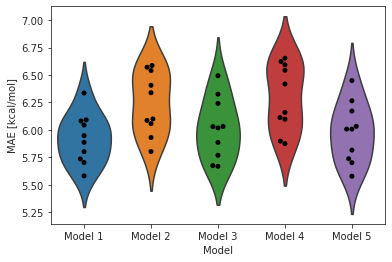

In [9]:
df_lgbm_soap = pd.DataFrame({'Model': [
    *['Model 1' for i in range(len(mae_lgbm_soap_se))],
    *['Model 2' for i in range(len(mae_lgbm_soap))],
    *['Model 3' for i in range(len(mae_lgbm_soap_se_noBDEs))],
    *['Model 4' for i in range(len(mae_lgbm_soap_noBDEs))],
    *['Model 5' for i in range(len(mae_lgbm_soap_DeltaH))]
], 'MAE [kcal/mol]': [
    *mae_lgbm_soap_se, *mae_lgbm_soap,
    *mae_lgbm_soap_se_noBDEs, *mae_lgbm_soap_noBDEs,
    *mae_lgbm_soap_DeltaH
]})

df_lgbm_soap.to_csv('cross_val_scores_lgbm_soap.csv')

plot_cross_val_scores(df_lgbm_soap)
plt.show()

### Using LMBTR descriptors

#### LMBTR descriptors of starting and end structures

In [ ]:
mae_lgbm_lmbtr_se = cross_val_score(model, data_lmbtr_se_scaled, data_lmbtr_se_target, scoring='neg_mean_absolute_error', cv = KFold(n_splits=10, shuffle=True, random_state=1))
print("Accuracy of Model with Cross Validation is:", mae_lgbm_lmbtr_se.mean(), "(+/- %0.2f)" % mae_lgbm_lmbtr_se.std())

#### LMBTR descriptors of starting structures

In [ ]:
mae_lgbm_lmbtr = cross_val_score(model, data_lmbtr_scaled, data_lmbtr_target, scoring='neg_mean_absolute_error', cv = KFold(n_splits=10, shuffle=True, random_state=1))
print("Accuracy of Model with Cross Validation is:", mae_lgbm_lmbtr.mean(), "(+/- %0.2f)" % mae_lgbm_lmbtr.std())

#### No BDEs, LMBTR descriptors of starting and end structures

In [ ]:
mae_lgbm_lmbtr_se_noBDEs = cross_val_score(model, data_lmbtr_se_noBDEs_scaled, data_lmbtr_se_noBDEs_target, scoring='neg_mean_absolute_error', cv = KFold(n_splits=10, shuffle=True, random_state=1))
print("Accuracy of Model with Cross Validation is:", mae_lgbm_lmbtr_se_noBDEs.mean(), "(+/- %0.2f)" % mae_lgbm_lmbtr_se_noBDEs.std())

#### No BDEs, LMBTR descriptors of starting structures

In [ ]:
mae_lgbm_lmbtr_noBDEs = cross_val_score(model, data_lmbtr_noBDEs_scaled, data_lmbtr_noBDEs_target, scoring='neg_mean_absolute_error', cv = KFold(n_splits=10, shuffle=True, random_state=1))
print("Accuracy of Model with Cross Validation is:", mae_lgbm_lmbtr_noBDEs.mean(), "(+/- %0.2f)" % mae_lgbm_lmbtr_noBDEs.std())

#### Using the enthalpy of reaction as a direct input

In [ ]:
mae_lgbm_lmbtr_DeltaH = cross_val_score(model, data_lmbtr_DeltaH_scaled, data_lmbtr_DeltaH_target, scoring='neg_mean_absolute_error', cv = KFold(n_splits=10, shuffle=True, random_state=1))
print("Accuracy of Model with Cross Validation is:", mae_lgbm_lmbtr_DeltaH.mean(), "(+/- %0.2f)" % mae_lgbm_lmbtr_DeltaH.std())

#### Comparison

In [11]:
mae_lgbm_lmbtr_se = np.load('mae_lgbm_lmbtr_se.npy')
mae_lgbm_lmbtr = np.load('mae_lgbm_lmbtr.npy')
mae_lgbm_lmbtr_se_noBDEs = np.load('mae_lgbm_lmbtr_se_noBDEs.npy')
mae_lgbm_lmbtr_noBDEs = np.load('mae_lgbm_lmbtr_noBDEs.npy')
mae_lgbm_lmbtr_DeltaH = np.load('mae_lgbm_lmbtr_DeltaH.npy')

In [12]:
mae_lgbm_lmbtr_se = -1*mae_lgbm_lmbtr_se
mae_lgbm_lmbtr = -1*mae_lgbm_lmbtr
mae_lgbm_lmbtr_se_noBDEs = -1*mae_lgbm_lmbtr_se_noBDEs
mae_lgbm_lmbtr_noBDEs = -1*mae_lgbm_lmbtr_noBDEs
mae_lgbm_lmbtr_DeltaH = -1*mae_lgbm_lmbtr_DeltaH

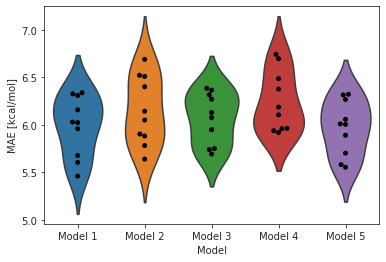

In [13]:
df_lgbm_lmbtr = pd.DataFrame({'Model': [
    *['Model 1' for i in range(len(mae_lgbm_lmbtr_se))],
    *['Model 2' for i in range(len(mae_lgbm_lmbtr))],
    *['Model 3' for i in range(len(mae_lgbm_lmbtr_se_noBDEs))],
    *['Model 4' for i in range(len(mae_lgbm_lmbtr_noBDEs))],
    *['Model 5' for i in range(len(mae_lgbm_lmbtr_DeltaH))]
], 'MAE [kcal/mol]': [
    *mae_lgbm_lmbtr_se, *mae_lgbm_lmbtr,
    *mae_lgbm_lmbtr_se_noBDEs, *mae_lgbm_lmbtr_noBDEs,
    *mae_lgbm_lmbtr_DeltaH
]})

df_lgbm_lmbtr.to_csv('cross_val_scores_lgbm_lmbtr.csv')

plot_cross_val_scores(df_lgbm_lmbtr)
plt.show()

## HistGradientBoostingRegressor

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [ ]:
model = HistGradientBoostingRegressor()

### Using SOAP descriptors

#### Comparison

In [2]:
mae_hgb_soap_se = np.load('mae_hgb_soap_se.npy')
mae_hgb_soap = np.load('mae_hgb_soap.npy')
mae_hgb_soap_se_noBDEs = np.load('mae_hgb_soap_se_noBDEs.npy')
mae_hgb_soap_noBDEs = np.load('mae_hgb_soap_noBDEs.npy')
mae_hgb_soap_DeltaH = np.load('mae_hgb_soap_DeltaH.npy')

In [3]:
mae_hgb_soap_se = -1*mae_hgb_soap_se
mae_hgb_soap = -1*mae_hgb_soap
mae_hgb_soap_se_noBDEs = -1*mae_hgb_soap_se_noBDEs
mae_hgb_soap_noBDEs = -1*mae_hgb_soap_noBDEs
mae_hgb_soap_DeltaH = -1*mae_hgb_soap_DeltaH

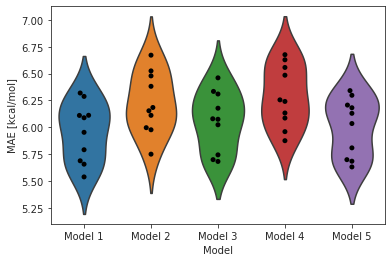

In [6]:
df_hgb_soap = pd.DataFrame({'Model': [
    *['Model 1' for i in range(len(mae_hgb_soap_se))],
    *['Model 2' for i in range(len(mae_hgb_soap))],
    *['Model 3' for i in range(len(mae_hgb_soap_se_noBDEs))],
    *['Model 4' for i in range(len(mae_hgb_soap_noBDEs))],
    *['Model 5' for i in range(len(mae_hgb_soap_DeltaH))]
], 'MAE [kcal/mol]': [
    *mae_hgb_soap_se, *mae_hgb_soap,
    *mae_hgb_soap_se_noBDEs, *mae_hgb_soap_noBDEs,
    *mae_hgb_soap_DeltaH
]})

df_hgb_soap.to_csv('cross_val_scores_hgb_soap.csv')

plot_cross_val_scores(df_hgb_soap)
plt.show()

### Using LMBTR descriptors

#### Comparison

In [7]:
mae_hgb_lmbtr_se = np.load('mae_hgb_lmbtr_se.npy')
mae_hgb_lmbtr = np.load('mae_hgb_lmbtr.npy')
mae_hgb_lmbtr_se_noBDEs = np.load('mae_hgb_lmbtr_se_noBDEs.npy')
mae_hgb_lmbtr_noBDEs = np.load('mae_hgb_lmbtr_noBDEs.npy')
mae_hgb_lmbtr_DeltaH = np.load('mae_hgb_lmbtr_DeltaH.npy')

In [8]:
mae_hgb_lmbtr_se = -1*mae_hgb_lmbtr_se
mae_hgb_lmbtr = -1*mae_hgb_lmbtr
mae_hgb_lmbtr_se_noBDEs = -1*mae_hgb_lmbtr_se_noBDEs
mae_hgb_lmbtr_noBDEs = -1*mae_hgb_lmbtr_noBDEs
mae_hgb_lmbtr_DeltaH = -1*mae_hgb_lmbtr_DeltaH

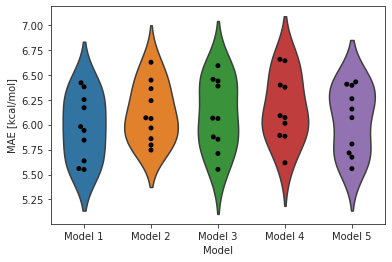

In [9]:
df_hgb_lmbtr = pd.DataFrame({'Model': [
    *['Model 1' for i in range(len(mae_hgb_lmbtr_se))],
    *['Model 2' for i in range(len(mae_hgb_lmbtr))],
    *['Model 3' for i in range(len(mae_hgb_lmbtr_se_noBDEs))],
    *['Model 4' for i in range(len(mae_hgb_lmbtr_noBDEs))],
    *['Model 5' for i in range(len(mae_hgb_lmbtr_DeltaH))]
], 'MAE [kcal/mol]': [
    *mae_hgb_lmbtr_se, *mae_hgb_lmbtr,
    *mae_hgb_lmbtr_se_noBDEs, *mae_hgb_lmbtr_noBDEs,
    *mae_hgb_lmbtr_DeltaH
]})

df_hgb_lmbtr.to_csv('cross_val_scores_hgb_lmbtr.csv')

plot_cross_val_scores(df_hgb_lmbtr)
plt.show()

## XGBRegressor

In [ ]:
from xgboost.sklearn import XGBRegressor

In [ ]:
model = XGBRegressor()

### Using SOAP descriptors

#### Comparison

In [10]:
mae_xgb_soap_se = np.load('mae_xgb_soap_se.npy')
mae_xgb_soap = np.load('mae_xgb_soap.npy')
mae_xgb_soap_se_noBDEs = np.load('mae_xgb_soap_se_noBDEs.npy')
mae_xgb_soap_noBDEs = np.load('mae_xgb_soap_noBDEs.npy')
mae_xgb_soap_DeltaH = np.load('mae_xgb_soap_DeltaH.npy')

In [11]:
mae_xgb_soap_se = -1*mae_xgb_soap_se
mae_xgb_soap = -1*mae_xgb_soap
mae_xgb_soap_se_noBDEs = -1*mae_xgb_soap_se_noBDEs
mae_xgb_soap_noBDEs = -1*mae_xgb_soap_noBDEs
mae_xgb_soap_DeltaH = -1*mae_xgb_soap_DeltaH

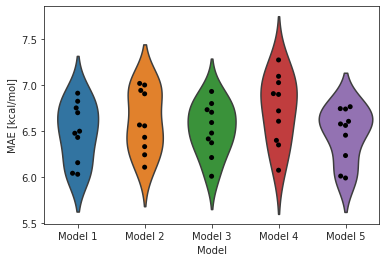

In [12]:
df_xgb_soap = pd.DataFrame({'Model': [
    *['Model 1' for i in range(len(mae_xgb_soap_se))],
    *['Model 2' for i in range(len(mae_xgb_soap))],
    *['Model 3' for i in range(len(mae_xgb_soap_se_noBDEs))],
    *['Model 4' for i in range(len(mae_xgb_soap_noBDEs))],
    *['Model 5' for i in range(len(mae_xgb_soap_DeltaH))]
], 'MAE [kcal/mol]': [
    *mae_xgb_soap_se, *mae_xgb_soap,
    *mae_xgb_soap_se_noBDEs, *mae_xgb_soap_noBDEs,
    *mae_xgb_soap_DeltaH
]})

df_xgb_soap.to_csv('cross_val_scores_xgb_soap.csv')

plot_cross_val_scores(df_xgb_soap)
plt.show()

### Using LMBTR descriptors

#### Comparison

In [13]:
mae_xgb_lmbtr_se = np.load('mae_xgb_lmbtr_se.npy')
mae_xgb_lmbtr = np.load('mae_xgb_lmbtr.npy')
mae_xgb_lmbtr_se_noBDEs = np.load('mae_xgb_lmbtr_se_noBDEs.npy')
mae_xgb_lmbtr_noBDEs = np.load('mae_xgb_lmbtr_noBDEs.npy')
mae_xgb_lmbtr_DeltaH = np.load('mae_xgb_lmbtr_DeltaH.npy')

In [14]:
mae_xgb_lmbtr_se = -1*mae_xgb_lmbtr_se
mae_xgb_lmbtr = -1*mae_xgb_lmbtr
mae_xgb_lmbtr_se_noBDEs = -1*mae_xgb_lmbtr_se_noBDEs
mae_xgb_lmbtr_noBDEs = -1*mae_xgb_lmbtr_noBDEs
mae_xgb_lmbtr_DeltaH = -1*mae_xgb_lmbtr_DeltaH

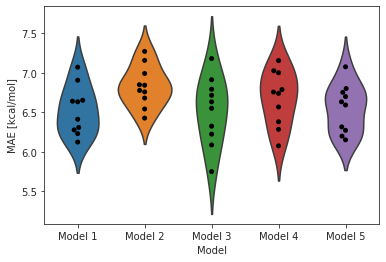

In [15]:
df_xgb_lmbtr = pd.DataFrame({'Model': [
    *['Model 1' for i in range(len(mae_xgb_lmbtr_se))],
    *['Model 2' for i in range(len(mae_xgb_lmbtr))],
    *['Model 3' for i in range(len(mae_xgb_lmbtr_se_noBDEs))],
    *['Model 4' for i in range(len(mae_xgb_lmbtr_noBDEs))],
    *['Model 5' for i in range(len(mae_xgb_lmbtr_DeltaH))]
], 'MAE [kcal/mol]': [
    *mae_xgb_lmbtr_se, *mae_xgb_lmbtr,
    *mae_xgb_lmbtr_se_noBDEs, *mae_xgb_lmbtr_noBDEs,
    *mae_xgb_lmbtr_DeltaH
]})

df_xgb_lmbtr.to_csv('cross_val_scores_xgb_lmbtr.csv')

plot_cross_val_scores(df_xgb_lmbtr)
plt.show()